In [57]:
%matplotlib widget
from matplotlib import pyplot as plt
import numpy as np
def plotscatter(X_transformed):
    if X_transformed.shape[1]==3:
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        ax.scatter(X_transformed[:209,0],X_transformed[:209,1],X_transformed[:209,2],c="r",label="fu")
        ax.scatter(X_transformed[209:209+696,0],X_transformed[209:209+696,1],X_transformed[209:209+696,2],c="g",label="notfu")
        ax.scatter(X_transformed[209+696:209+696+5,0],X_transformed[209+696:209+696+5,1],X_transformed[209+696:209+696+5,2],c="b",label="testfu")
        ax.scatter(X_transformed[-5:,0],X_transformed[-5:,1],X_transformed[-5:,2],c="y",label="testnotfu")
        ax.legend()
        ax.grid(True)

        plt.show()
    elif X_transformed.shape[1]==2:
        fig = plt.figure()
        ax = fig.add_subplot()
        ax.scatter(X_transformed[:209,0],X_transformed[:209,1],c="r",label="fu")
        ax.scatter(X_transformed[209:209+696,0],X_transformed[209:209+696,1],c="g",label="notfu")
        ax.scatter(X_transformed[209+696:209+696+5,0],X_transformed[209+696:209+696+5,1],c="b",label="testfu")
        ax.scatter(X_transformed[-5:,0],X_transformed[-5:,1],c="y",label="testnotfu")
        ax.legend()
        ax.grid(True)

        plt.show()
    elif X_transformed.shape[1]==1:
        fig = plt.figure()
        ax = fig.add_subplot()
        ax.scatter(X_transformed[:209,0],0*np.ones(209),c="r",label="fu")
        ax.scatter(X_transformed[209:209+696,0],1*np.ones(696),c="g",label="notfu")
        ax.scatter(X_transformed[209+696:209+696+5,0],2*np.ones(5),c="b",label="testfu")
        ax.scatter(X_transformed[-5:,0],3*np.ones(5),c="y",label="testnotfu")
        ax.legend()
        ax.grid(True)

In [180]:
from skimage import morphology,draw
import numpy as np
import matplotlib.pyplot as plt
import cv2

def readimage(t_name):
    image = cv2.imread(t_name,cv2.IMREAD_GRAYSCALE)
    ret,image=cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    image=255-image

    #实施骨架算法
    skeleton =morphology.skeletonize(image)

    skeleton=255-skeleton
    image=255-image
    skeleton[skeleton!=255]=0
    return image,skeleton

In [181]:
def features0(img):
    sumleft=np.zeros((4))
    for i in range(4):
        for x in range(125):
            for y in range(500):
                if img[x+i*125][y]==0:
                    sumleft[i]+=y

    sumright=np.zeros((4))
    for i in range(4):
        for x in range(125):
            for y in range(500):
                if img[x+i*125][499-y]==0:
                    sumright[i]+=y

    sumup=np.zeros((4))
    for i in range(4):
        for y in range(125):
            for x in range(500):
                if img[x][y+i*125]==0:
                    sumup[i]+=x

    sumdown=np.zeros((4))
    for i in range(4):
        for y in range(125):
            for x in range(500):
                if img[499-x][y+i*125]==0:
                    sumdown[i]+=x

    feature2=np.concatenate((sumleft,sumright,sumup,sumdown),axis=0)
    sumleft3=np.zeros((4))
    for i in range(4):
        for x in range(125):
            flag=0
            begin=0
            for y in range(500):
                if img[x+i*125][y]==0 and flag==0:
                    flag+=1
                if img[x+i*125][y]==255 and flag==1:
                    flag+=1
                    begin=y
                if img[x+i*125][y]==0 and flag==2:
                    flag+=1
                    sumleft3[i]+=y-begin

    sumright3=np.zeros((4))
    for i in range(4):
        for x in range(125):
            flag=0
            begin=0
            for y in range(500):
                if img[x+i*125][499-y]==0  and flag==0:
                    flag+=1
                if img[x+i*125][499-y]==255  and flag==1:
                    flag+=1
                    begin=y
                if img[x+i*125][499-y]==0  and flag==2:
                    flag+=1
                    sumright3[i]+=y-begin

    sumup3=np.zeros((4))
    for i in range(4):
        for y in range(125):
            flag=0
            begin=0
            for x in range(500):
                if img[x][y+i*125]==0 and flag==0:
                    flag+=1
                if img[x][y+i*125]==255 and flag==1:
                    flag+=1
                    begin=x
                if img[x][y+i*125]==0 and flag==2:
                    flag+=1
                    sumup3[i]+=x-begin

    sumdown3=np.zeros((4))
    for i in range(4):
        for y in range(125):
            flag=0
            begin=0
            for x in range(500):
                if img[499-x][y+i*125]==0 and flag==0:
                    flag+=1
                if img[499-x][y+i*125]==255 and flag==1:
                    flag+=1
                    begin=x
                if img[499-x][y+i*125]==0 and flag==2:
                    flag+=1
                    sumdown3[i]+=x-begin

    feature3=np.concatenate((sumleft3,sumright3,sumup3,sumdown3),axis=0)
    feature23=np.concatenate((feature2,feature3),axis=0)
    return feature23

In [183]:
def get_feature23(t_name):
    _,skeleton=readimage(t_name)
    return features0(skeleton)

In [19]:
import numpy as np
from feature import feature
import os
from tqdm import tqdm


pathfu = "./traindata/fu/"
pathnotfu = "./traindata/not_fu/"
pathtest = "./testdata/"

data=np.zeros((209+696+10,133956))
y = np.concatenate((np.ones(209), 0*np.ones(696),np.ones(5), 0*np.ones(5)))

all=[pathfu + i for i in os.listdir(pathfu)]+[pathnotfu + i for i in os.listdir(pathnotfu)]+[pathtest + i for i in os.listdir(pathtest)]
for index,i in enumerate(tqdm(all)):
    data[index]=feature(i,"hog",False).flatten()

100%|██████████| 915/915 [00:21<00:00, 42.41it/s]


In [184]:
import multiprocessing
char_feat=np.zeros((209+696+10,32))
num_processes = multiprocessing.cpu_count()-1 # 使用核心数
pool = multiprocessing.Pool(processes=num_processes) # 实例化进程池
result=pool.map(get_feature23,all)
for i in range(len(result)):
    char_feat[i]=result[i]

In [194]:
def normalization(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range

char_feat_norm=normalization(char_feat)

In [205]:
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
embedding = make_pipeline(StandardScaler(),
                          LocallyLinearEmbedding(n_neighbors=10,
                                                 n_components=3,
                                                 method="modified",
                                                 eigen_solver='dense'))
X = embedding.fit_transform(data)
X.shape

(915, 3)

In [127]:
from sklearn.manifold import MDS
embedding = MDS(n_components=3, normalized_stress='auto')
X = embedding.fit_transform(data)

In [68]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf = LinearDiscriminantAnalysis()
clf.fit(data[:209+696,:], y[:209+696])
X=clf.transform(data)

In [125]:
from sklearn.manifold import Isomap
embedding = Isomap(n_components=3)
X = embedding.fit_transform(data)
X.shape

(915, 3)

In [207]:
from sklearn.manifold import SpectralEmbedding
embedding = SpectralEmbedding(n_components=3)
X = embedding.fit_transform(data)
X.shape

(915, 3)

In [163]:
from sklearn.manifold import TSNE
X = TSNE(n_components=3).fit_transform(data)
X.shape

(915, 3)

In [97]:
X.shape

(915, 3)

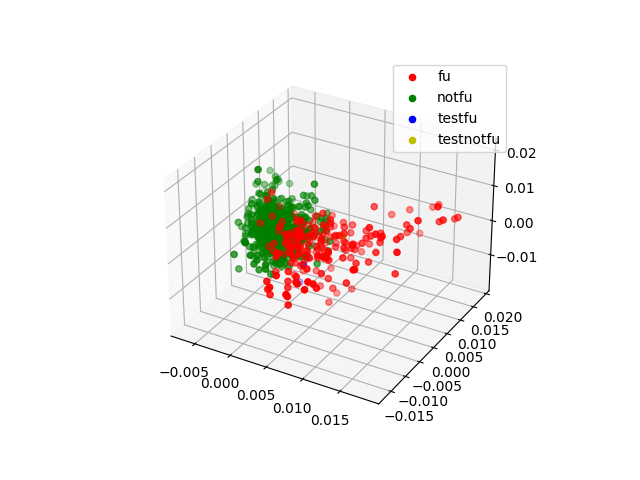

In [208]:
plotscatter(X)

In [172]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
X=pca.fit_transform(data)

In [209]:
X=np.concatenate((X,char_feat_norm),axis=1)
X.shape

(915, 35)

In [210]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X[:-10,:], y[:-10], test_size=0.2, random_state=42
)
X_test=X[-10:,:]
y_test=y[-10:]

In [211]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

clf = make_pipeline(
    AdaBoostClassifier(n_estimators=50, random_state=0)
)
clf.fit(X_train, y_train)

Pipeline(steps=[('adaboostclassifier', AdaBoostClassifier(random_state=0))])

In [217]:

from sklearn.metrics import f1_score
from hyperopt import hp
import xgboost as xgb

def train(args):
    learning_rate=args["learning_rate"]
    n_estimators=args["n_estimators"]
    eta=args["eta"]
    max_depth=args["max_depth"]
    subsample=args["subsample"]
    colsample_bytree=args["colsample_bytree"]
    min_child_weight=args["min_child_weight"]
    reg_alpha=args["reg_alpha"]
    reg_lambda=args["reg_lambda"]

    model = xgb.XGBClassifier(learning_rate=learning_rate,n_estimators=n_estimators,eta=eta,
                              max_depth=max_depth,subsample=subsample,colsample_bytree=colsample_bytree,
                              min_child_weight=min_child_weight,reg_alpha=reg_alpha,reg_lambda=reg_lambda)
    model.fit(X_train, y_train)
    return model

def objective(args):
    model=train(args)
    y_pred=model.predict(X_val)
    f1=f1_score(y_val,y_pred,average="macro")
    return -f1

space={"learning_rate":hp.choice("learning_rate", [0.1]),
    "n_estimators":hp.choice("n_estimators",[50, 100, 150, 200, 300]), # 多少棵树
    "eta": hp.choice("eta",[0.05, 0.1, 0, 2, 0.3]),  # 学习率
    "max_depth": hp.choice("max_depth",range(2, 15, 1)),  # 树的最大深度
    "subsample": hp.uniform("subsample", 0.7, 0.9),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.4, 0.98),  # 选择多少列构建一个树
    "min_child_weight": hp.choice("min_child_weight",range(1, 9, 1)),  # 叶子节点最小样本数目
    "reg_alpha": hp.choice("reg_alpha",[0, 0.01, 0.02, 0.05, 0.7, 0.1, 1]),
    "reg_lambda": hp.choice("reg_lambda",[0, 0.1, 0.5, 1])}

from hyperopt import fmin, tpe, space_eval
best = fmin(objective, space, algo=tpe.suggest, max_evals=500)
print(best)
print(space_eval(space, best))
clf=train(space_eval(space, best))

100%|██████████| 500/500 [01:01<00:00,  8.17trial/s, best loss: -1.0]               
{'colsample_bytree': 0.40259312061141755, 'eta': 4, 'learning_rate': 0, 'max_depth': 10, 'min_child_weight': 2, 'n_estimators': 2, 'reg_alpha': 3, 'reg_lambda': 3, 'subsample': 0.7891340781174342}
{'colsample_bytree': 0.40259312061141755, 'eta': 0.3, 'learning_rate': 0.1, 'max_depth': 12, 'min_child_weight': 3, 'n_estimators': 150, 'reg_alpha': 0.05, 'reg_lambda': 1, 'subsample': 0.7891340781174342}


In [214]:
from sklearn.ensemble import RandomForestClassifier

clf = make_pipeline(RandomForestClassifier())
clf.fit(X_train, y_train)

Pipeline(steps=[('randomforestclassifier', RandomForestClassifier())])

In [218]:
from sklearn.metrics import f1_score

y_pred = clf.predict(X_val)
print(f1_score(y_val, y_pred, average="macro"))
from sklearn.metrics import confusion_matrix

confusion_matrix(y_val, y_pred)

1.0


array([[143,   0],
       [  0,  38]])

In [219]:
y_pred = clf.predict(X_test)
print(y_pred)
print(f1_score(y_test,y_pred, average="macro"))
print(confusion_matrix(y_pred, y_test))

[0 0 1 1 1 0 0 0 1 1]
0.6
[[3 2]
 [2 3]]
